In [1]:
import os
import cv2
import torch
import imutils
import numpy as np
from os.path import join as pjoin
from skimage import exposure, img_as_ubyte
from imutils.perspective import four_point_transform
from itertools import combinations
from torchvision import transforms
import matplotlib.pyplot as plt
from models import get_model
from collections import OrderedDict

In [2]:
PROCESS_SIZE = 1000
MODEL_INPUT_SIZE = 1000

In [3]:
model_arch = 'UNetRNN'
model_path = "CRDN1000.pkl"

In [5]:
path="../../matricule/carteGrise/"
imgs=os.listdir(path)

In [6]:
def convert_state_dict(state_dict):
    """Converts a state dict saved from a dataParallel module to normal
       module state_dict inplace
       :param state_dict is the loaded DataParallel model_state
    """
    if not next(iter(state_dict)).startswith("module."):
        return state_dict  # abort if dict is not a DataParallel model_state
    new_state_dict = OrderedDict()
    for k, v in state_dict.items():
        item_name = k[7:]  # remove `module.`
        new_state_dict[item_name] = v
    return new_state_dict


In [7]:
def load_model():
    device = torch.device("cuda:{}".format(0) if torch.cuda.is_available() else "cpu")
    try:
        model = get_model({'arch': model_arch}, n_classes=2).to(device)
        state = convert_state_dict(torch.load(model_path, map_location=device)["model_state"])
        model.load_state_dict(state)
        model.eval()
        model.to(device)
    except:
        print("Model Error: Model \'" + model_arch + "\' import failed, please check the model file.")
        sys.exit()

    return model, device


In [8]:
def detect_edge(img):
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    gray = cv2.normalize(gray, None, 0, 255, cv2.NORM_MINMAX)

    mean_gray = cv2.mean(gray)
    TH_LIGHT = 150
    if mean_gray[0] > TH_LIGHT:
        gray = exposure.adjust_gamma(gray, gamma=6)
        gray = exposure.equalize_adapthist(gray, kernel_size=None, clip_limit=0.02)
        gray = img_as_ubyte(gray)

    kernel = np.ones((15, 15), np.uint8)
    closing = cv2.morphologyEx(gray, cv2.MORPH_CLOSE, kernel)
    blurred = cv2.medianBlur(closing, 5)
    blurred = cv2.bilateralFilter(blurred, d=0, sigmaColor=15, sigmaSpace=10)

    edged = cv2.Canny(blurred, 75, 200)

    return edged

In [9]:
def detect_edge_cnn(img, model, device):
    image = cv2.resize(img, (MODEL_INPUT_SIZE, int(MODEL_INPUT_SIZE * img.shape[0] / img.shape[1])),
                       interpolation=cv2.INTER_LINEAR)
    tf = transforms.Compose(
        [
            transforms.ToTensor(),
            transforms.Normalize([0.196, 0.179, 0.323], [0.257, 0.257, 0.401])
        ]
    )
    image = tf(image)
    image = image.unsqueeze(0)

    with torch.no_grad():
        img_val = image.to(device)
        res = model(img_val)
        pred = np.squeeze(res.data.max(1)[1].cpu().numpy())

    return pred

In [10]:
# get cross point of two lines (intersection of two lines)
def cross_point(line1, line2):
    x = 0
    y = 0
    x1 = line1[0]
    y1 = line1[1]
    x2 = line1[2]
    y2 = line1[3]
    x3 = line2[0]
    y3 = line2[1]
    x4 = line2[2]
    y4 = line2[3]
    if (x2 - x1) == 0:
        k1 = None
    else:
        k1 = (y2 - y1) * 1.0 / (x2 - x1)
        b1 = y1 * 1.0 - x1 * k1 * 1.0
    if (x4 - x3) == 0:
        k2 = None
        b2 = 0
    else:
        k2 = (y4 - y3) * 1.0 / (x4 - x3)
        b2 = y3 * 1.0 - x3 * k2 * 1.0
    if k1 is None:
        if not k2 is None:
            x = x1
            y = k2 * x1 + b2
    elif k2 is None:
        x = x3
        y = k1 * x3 + b1
    elif not k2 == k1:
        x = (b2 - b1) * 1.0 / (k1 - k2)
        y = k1 * x * 1.0 + b1 * 1.0

    return [x, y]


In [11]:
# get angle of two lines
def get_angle(sta_point, mid_point, end_point):
    ma_x = sta_point[0][0] - mid_point[0][0]
    ma_y = sta_point[0][1] - mid_point[0][1]
    mb_x = end_point[0][0] - mid_point[0][0]
    mb_y = end_point[0][1] - mid_point[0][1]
    ab_x = sta_point[0][0] - end_point[0][0]
    ab_y = sta_point[0][1] - end_point[0][1]
    ab_val2 = ab_x * ab_x + ab_y * ab_y
    ma_val2 = ma_x * ma_x + ma_y * ma_y
    mb_val2 = mb_x * mb_x + mb_y * mb_y
    cos_M = (ma_val2 + mb_val2 - ab_val2) / (2 * np.sqrt(ma_val2) * np.sqrt(mb_val2))
    angleAMB = np.arccos(cos_M) / np.pi * 180
    return angleAMB


In [12]:
# see if 4 points can form a quadrilateral
def checked_valid_transform(approx):
    hull = cv2.convexHull(approx)
    TH_ANGLE = 45
    if len(hull) == 4:
        for i in range(4):
            p1 = hull[(i - 1) % 4]
            p2 = hull[i]
            p3 = hull[(i + 1) % 4]
            angel = get_angle(p1, p2, p3)
            if 90 - TH_ANGLE < angel < 90 + TH_ANGLE:
                continue
    return True


In [13]:
def get_cnt(edged, img, ratio):
    kernel = np.ones((3, 3), np.uint8)
    #dilatation
    edged = cv2.dilate(edged, kernel, iterations=1)
    mask = np.zeros((edged.shape[0], edged.shape[1]), np.uint8)
    mask[10:edged.shape[0] - 10, 10:edged.shape[1] - 10] = 1
    edged = edged * mask
    
    #contours
    cnts = cv2.findContours(edged.copy(), cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_NONE)
    # cnts = cnts[0] if imutils.is_cv2() else cnts[1]
    cnts = cnts[0] if imutils.is_cv2(or_better=True) else cnts[1]
    cnts = sorted(cnts, key=lambda c: cv2.arcLength(c, True), reverse=True)
    edgelines = np.zeros(edged.shape, np.uint8)
    cNum = 4

    for i in range(min(cNum, len(cnts))):
        TH = 1 / 20.0
        if cv2.contourArea(cnts[i]) < TH * img.shape[0] * img.shape[1]:
            cv2.drawContours(edgelines, [cnts[i]], 0, (255, 255, 255), -1)
        else:
            cv2.drawContours(edgelines, [cnts[i]], 0, (1, 1, 1), -1)
            edgelines = edgelines * edged
            break
        cv2.drawContours(edgelines, [cnts[i]], 0, (255, 255, 255), -1)

    lines = cv2.HoughLines(edgelines, 1, np.pi / 180, 200)


    strong_lines = np.zeros([4, 1, 2])
    n2 = 0

    for n1 in range(0, len(lines)):
        if n2 == 4:
            break
        for rho, theta in lines[n1]:
            if n1 == 0:
                strong_lines[n2] = lines[n1]
                n2 = n2 + 1
            else:
                c1 = np.isclose(abs(rho), abs(strong_lines[0:n2, 0, 0]), atol=80)
                c2 = np.isclose(np.pi - theta, strong_lines[0:n2, 0, 1], atol=np.pi / 36)
                c = np.all([c1, c2], axis=0)
                if any(c):
                    continue
                closeness_rho = np.isclose(rho, strong_lines[0:n2, 0, 0], atol=40)
                closeness_theta = np.isclose(theta, strong_lines[0:n2, 0, 1], atol=np.pi / 36)
                closeness = np.all([closeness_rho, closeness_theta], axis=0)
                if not any(closeness) and n2 < 4 and theta != 0:
                    strong_lines[n2] = lines[n1]
                    n2 = n2 + 1

    # draw strong lines
    lines1 = np.zeros((len(strong_lines), 4), dtype=int)
    for i in range(0, len(strong_lines)):
        rho, theta = strong_lines[i][0][0], strong_lines[i][0][1]
        a = np.cos(theta)
        b = np.sin(theta)
        x0 = a * rho
        y0 = b * rho
        lines1[i][0] = int(x0 + 1000 * (-b))
        lines1[i][1] = int(y0 + 1000 * (a))
        lines1[i][2] = int(x0 - 1000 * (-b))
        lines1[i][3] = int(y0 - 1000 * (a))


    approx = np.zeros((len(strong_lines), 1, 2), dtype=int)
    index = 0
    combs = list((combinations(lines1, 2)))
    for twoLines in combs:
        x1, y1, x2, y2 = twoLines[0]
        x3, y3, x4, y4 = twoLines[1]
        [x, y] = cross_point([x1, y1, x2, y2], [x3, y3, x4, y4])
        if 0 < x < img.shape[1] and 0 < y < img.shape[0] and index < 4:
            cv2.circle(img, (int(x), int(y)), 5, (0, 0, 255), 3)
            approx[index] = (int(x), int(y))
            index = index + 1

    if checked_valid_transform(approx):
        return approx * ratio

In [14]:
input_path=path+imgs[0]

In [16]:
input_path

In [18]:
image = cv2.imread(input_path)
image=cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
img = cv2.resize(image, (PROCESS_SIZE, int(PROCESS_SIZE * image.shape[0] / image.shape[1])))
ratio = image.shape[1] / PROCESS_SIZE

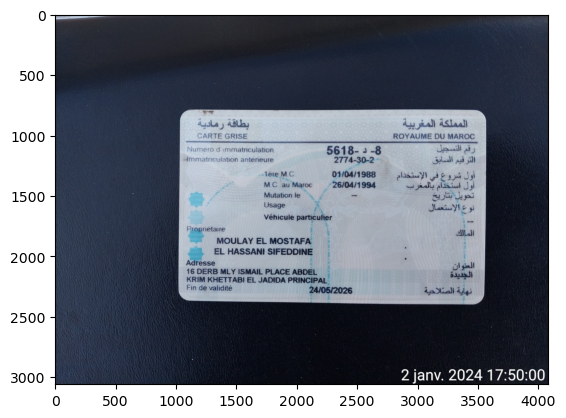

In [19]:
plt.imshow(image)

In [20]:
trained_model, device = load_model()

In [21]:
try:
    predict = detect_edge_cnn(image, trained_model, device)
    corners=get_cnt((predict*255).astype(np.uint8), img, ratio) # return the 4 corners
    if np.any(corners==0):
        predict = detect_edge(img)
        corners = get_cnt(predict, img, ratio)
except:
    try:
        predict = detect_edge(img)
        corners = get_cnt(predict, img, ratio)
    except:
        print("Something wrong, try another image")

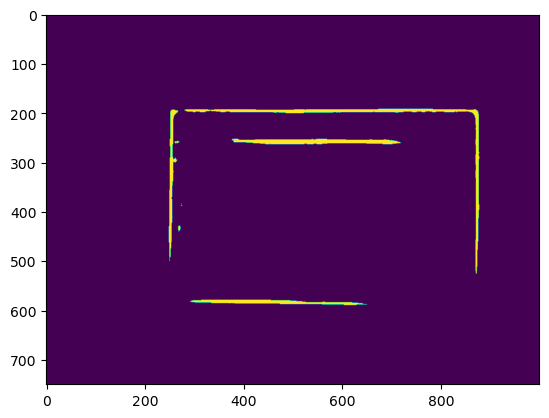

In [22]:
plt.imshow(predict)

In [23]:
result = four_point_transform(image, corners.reshape(4, 2))

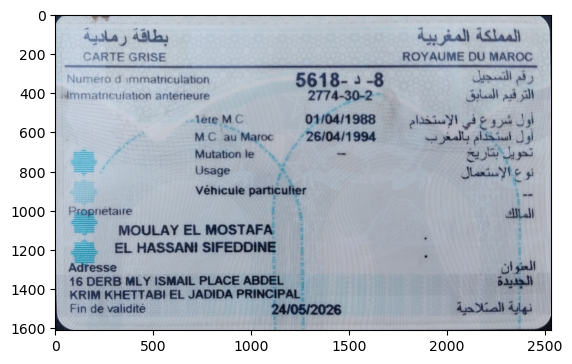

In [24]:
plt.imshow(result)

In [25]:
def returnCard(croppedImg):
    h,w,c=croppedImg.shape
    top_percent = 0.145
    bottom_percent = 0.24
    left_percent = 0.45
    right_percent = 0.72
    top = int(h * top_percent)
    bottom = int(h * bottom_percent)
    left = int(w * left_percent)
    right = int(w * right_percent)
    coord=croppedImg[top:bottom, left:right]
    return coord


In [26]:
cropped=returnCard(result)

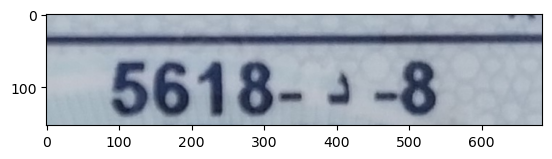

In [27]:
plt.imshow(cropped)